# Laboratory #4_1 : Image Classification using CNN

At the end of this laboratory, you would get familiarized with

*   Creating deep networks using Keras
*   Steps necessary in training a neural network
*   Prediction and performance analysis using neural networks
*   Using pre-trained networks
*   Feature visualizations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

# **Colaboratory environment**
By default, Colab notebooks run on CPU.
You can switch your notebook to run with GPU.

In order to obtain access to the GPU, you need to choose the tab Runtime and then select “Change runtime type” as shown in the following figure:

![Changing runtime](https://miro.medium.com/max/747/1*euE7nGZ0uJQcgvkpgvkoQg.png)

When a pop-up window appears select GPU. Ensure “Hardware accelerator” is set to GPU.

In [ ]:
import numpy as np
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import to_categorical
from keras.backend import clear_session
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Resizing
from keras.optimizers import SGD
from keras.applications import InceptionV3
from keras.applications import ResNet50
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing

In [ ]:
# Auxiliar handcrafted function to plot n images easily
def plot_images(images, size=(10,10), width=0, height=0, limits=[], titles=[], rectangles=[]):
  assert len(images) == len(limits) or limits == [], "Define a number of limits according to the number of images"
  if not width : width  = len(images)
  if not height: height = 1
  fig, axs = plt.subplots(height,width,figsize=size)
  for idx,image in enumerate(images):
    if width != 1 and height != 1:
      axs = axs.flatten()
    ax = axs if width == 1 and height == 1 else axs[idx]
    lim = limits[idx] if limits != [] else (None,None)
    title = titles[idx] if titles != [] else None
    ax.imshow(image, cmap='gray', vmin = lim[0], vmax = lim[1])
    if rectangles and idx < len(rectangles):
      (bestY, bestX), width, heigth, color = rectangles[idx]
      rect = patches.Rectangle((bestY, bestX), width, heigth, linewidth=1, edgecolor=color, facecolor='none')
      ax.add_patch(rect)
    ax.set_title(title)
    ax.set_xticks([]); 
    ax.set_yticks([])
  plt.show()

In [ ]:
random_state = 33

# **Working with a new dataset: CIFAR-10**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. More information about CIFAR-10 can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In Keras, the CIFAR-10 dataset is also preloaded in the form of four Numpy arrays. x_train and y_train contain the training set, while x_test and y_test contain the test data. The images are encoded as Numpy arrays and their corresponding labels ranging from 0 to 9.

Your task is to:

*   Visualize the images in CIFAR-10 dataset. Create a 10 x 10 plot showing 10 random samples from each class.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.




## Read the data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

n_labels = len(np.unique(y_train))

print("Train images shape:", x_train.shape)
print("Test images shape:", x_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

170498071/170498071 [==============================] - 14s 0us/step
Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Train labels shape: (50000,)
Test labels shape: (10000,)


Notice that we have 50k color images (3 channels) of size 32x32 pixels and 10k for the test set of the same size.

## Show the data

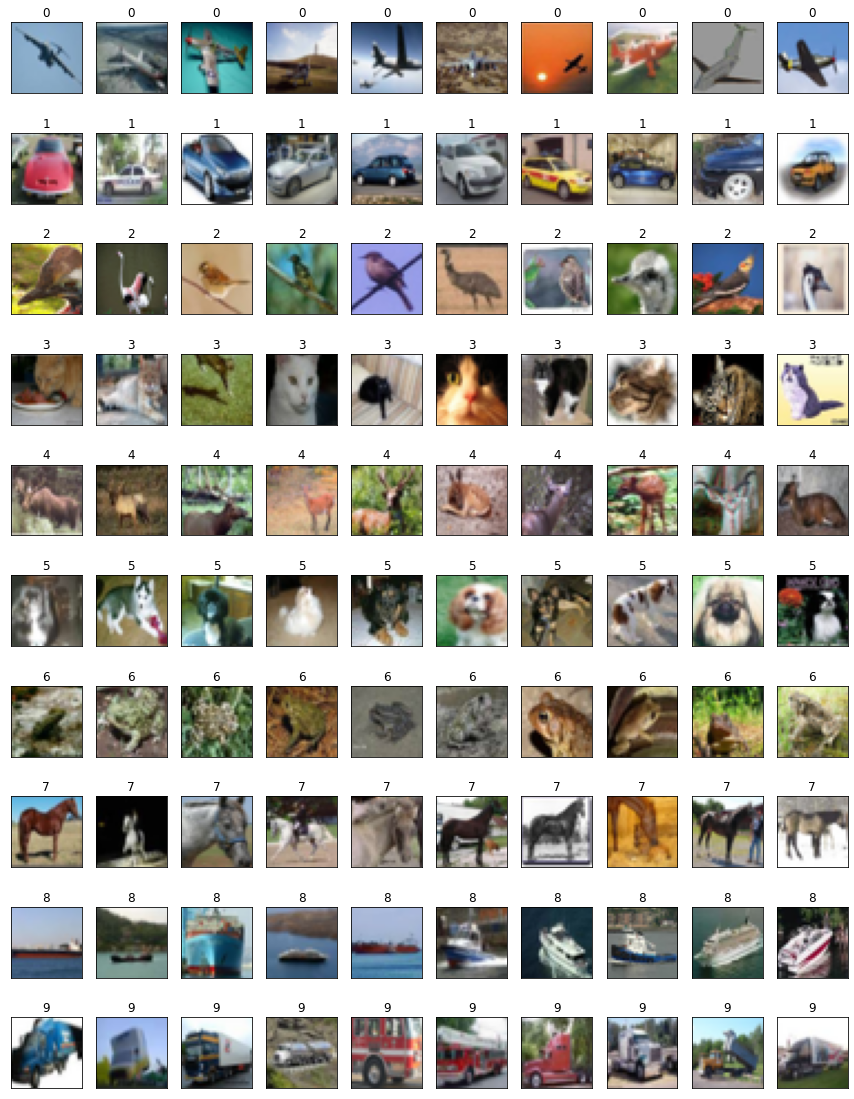

In [ ]:
images = []
labels = []
n_random_images = 10
for label in range(n_labels): # from 0 to 10
  indices = np.where(y_train.squeeze() == label)[0]
  random_indices = np.random.choice(indices, n_random_images)
  for image in x_train[random_indices]:
    images.append(image)
    labels.append(label)

plot_images(images, size=(15,20), height=10, width=10, titles=labels)

In [ ]:
categories = ["Plane","Car","Bird","Cat","Deer","Dog","Frog","Horse","Boat","Truck"]

On the images above we can see which are the categories of the dataset and 10 random examples of each one. We had defined the array *categories* in order to better plot the confussion matrices we will see in the next sections.

## Data normalization

We did this in order to normalize between 0 and 1 the values of all the images.

In [ ]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Preparing the labels

We prepare the labels to one hot encoding in order to use the next's section networks.

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


## Define the following model (same as the one in tutorial)

**For the convolutional front-end, start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. Use the input as (32,32,3). The filter maps can then be flattened to provide features to the classifier. Use a dense layer with 100 units before the classification layer (which is also a dense layer with softmax activation).**

In [ ]:
clear_session()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 100)               819300    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 821,206
Trainable params: 821,206
Non-trainable params: 0
__________________________________________________

*   **Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.**
*   **Use the above defined model to train CIFAR-10 and train the model for 512 epochs with a batch size of 32.**

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size=32, epochs=25, validation_split=0.1)

Epoch 1/512
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2782 - accuracy: 0.9163 - val_loss: 1.3647 - val_accuracy: 0.6376
Epoch 2/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2518 - accuracy: 0.9249 - val_loss: 1.3192 - val_accuracy: 0.6464
Epoch 3/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2321 - accuracy: 0.9329 - val_loss: 1.4125 - val_accuracy: 0.6374
Epoch 4/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2151 - accuracy: 0.9386 - val_loss: 1.7437 - val_accuracy: 0.5992
Epoch 5/512
1407/1407 [==============================] - 5s 3ms/step - loss: 0.1944 - accuracy: 0.9465 - val_loss: 1.3388 - val_accuracy: 0.6568
Epoch 6/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1782 - accuracy: 0.9537 - val_loss: 1.7255 - val_accuracy: 0.5948
Epoch 7/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1615 - accuracy: 0.9593 - val_loss: 1.5418 - val_ac

## Results


### Train
On this followint plot we show the cross entropy loss results for the net using the train and validation set. We can also see the accuracy and the validation accuracy in the second subplot. 

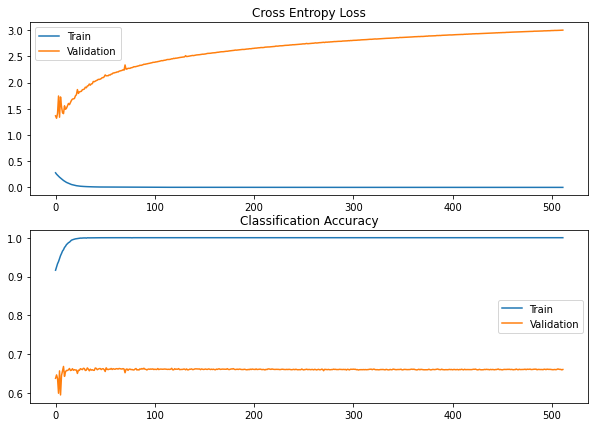

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,7))
ax1.set_title('Cross Entropy Loss')
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.legend()

ax2.set_title('Classification Accuracy')
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.legend()
plt.show()

We can see from the image above that this network is making a huge overfit to the data. With only a few epochs, the train's accuracy (loss) reaches 1 (0). The network is overfitting because we can see that, after some fluctuations in the validation values, these ones stagnate or even get worse, such as the cross-entropy loss.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.9795 - accuracy: 0.6556
Test loss: 2.9794976711273193
Test accuracy: 0.6556000113487244


### Test
Considering the test set, we can also check that the network is overfitting because the accuracy is only 65% (compared to the 100% of the training set). Now we will take a look at the confusion matrix to see in detail the misclassification that was made.

In [ ]:
y_test_pred = model.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


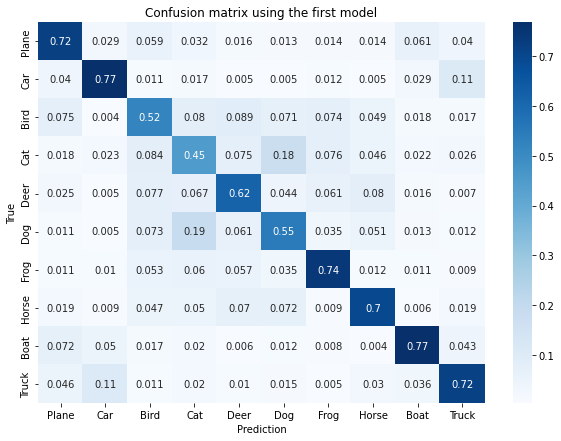

In [ ]:
fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label,normalize="true")
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the first model")
plt.show()

We can see that there are two distinct groups that have varying degrees of difficulty being identified. Specifically, most of the categories are correctly labeled with around 72% accuracy, while there are 4 classes (bird, cat, deer and dog) that have a bit more problems with the task. Furthermore, it is very interesting to see that the model is having issues with cats and dogs, which are categories that the model frequently misclassifies one for the other. This is probably due to the fact that the images of cats and dogs are taken from similar perspectives and are indeed really similar. However, we can see a clear diagonal in the confusion matrix that leads to the conclusion that the model is not performing as badly as it seems. Even so, the overfitting produced by this network is far from acceptable, as its capacity to generalize is really skewed.

## Defining Deeper Architectures: VGG Models

*   Define a deeper model architecture for CIFAR-10 dataset. We will use VGG model as the architecture.

**Stack two convolutional layers with 32 filters, each of 3 x 3. Use a max pooling layer and next flatten the output of the previous layer and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**


In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(10, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                      

In [ ]:
%%time
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=32, epochs=25, validation_split=0.1)

Epoch 1/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3399 - accuracy: 0.5209 - val_loss: 1.2740 - val_accuracy: 0.5398
Epoch 2/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1658 - accuracy: 0.5903 - val_loss: 1.1646 - val_accuracy: 0.5844
Epoch 3/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0495 - accuracy: 0.6321 - val_loss: 1.1141 - val_accuracy: 0.6076
Epoch 4/512
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9519 - accuracy: 0.6700 - val_loss: 1.0602 - val_accuracy: 0.6248
Epoch 5/512
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8720 - accuracy: 0.6960 - val_loss: 1.1420 - val_accuracy: 0.6090
Epoch 6/512
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7921 - accuracy: 0.7254 - val_loss: 1.0610 - val_accuracy: 0.6404
Epoch 7/512
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7203 - accuracy: 0.7525 - val_loss: 1.0581 - val_ac

*   **Compare the performance of both the models by plotting the loss and accuracy curves of both the training steps. Does the deeper model perform better? Comment on the observation.**
 

In [ ]:
def plot_loss_accuracy(history1, history2, name1, name2):
  fig, (axs1,axs2) = plt.subplots(2,2,figsize=(20,10))
  axs1[0].set_title('Loss')
  axs1[0].plot(history1.history['loss'], label=f'{name1} model')
  axs1[0].plot(history2.history['loss'], label=f'{name2} model')
  axs1[0].legend()

  axs1[1].set_title('Validation loss')
  axs1[1].plot(history1.history['val_loss'], label=f'{name1} model')
  axs1[1].plot(history2.history['val_loss'], label=f'{name2} model')
  axs1[1].legend()

  axs2[0].set_title('Accuracy')
  axs2[0].plot(history1.history['accuracy'], label=f'{name1} model')
  axs2[0].plot(history2.history['accuracy'], label=f'{name2} model')
  axs2[0].legend()

  axs2[1].set_title('Validation accuracy')
  axs2[1].plot(history1.history['val_accuracy'], label=f'{name1} model')
  axs2[1].plot(history2.history['val_accuracy'], label=f'{name2} model')
  axs2[1].legend()
  plt.show()

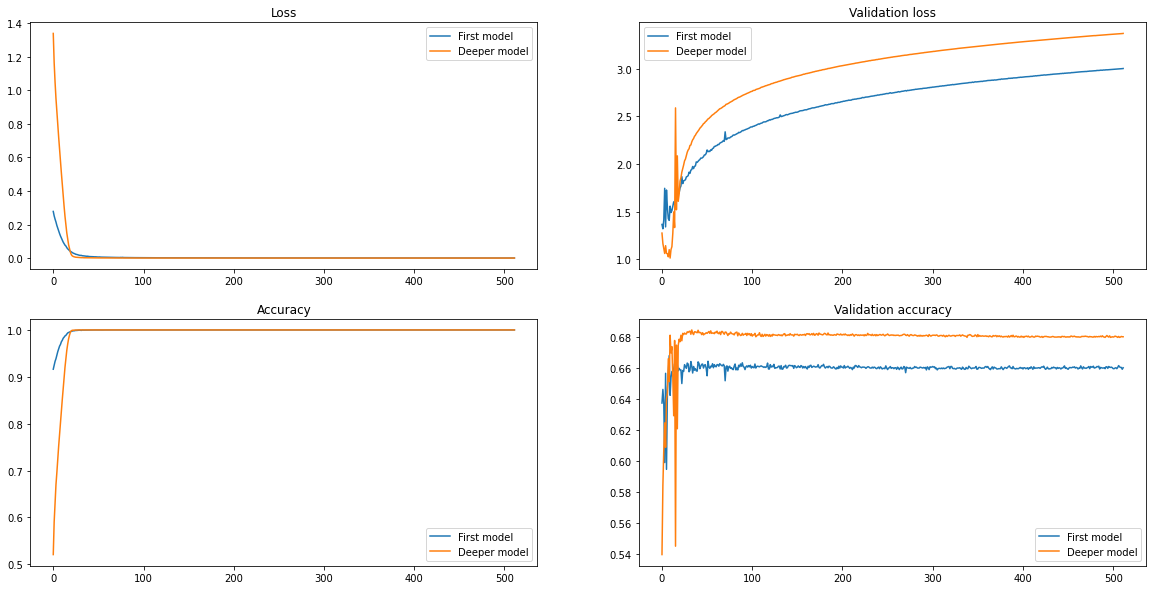

In [ ]:
plot_loss_accuracy(history, history2, "First", "Deeper")

In the previous plots, we can see the comparison between the first and the deeper model. We can see how both of them have similar behaviors. The deeper model, on the other hand, faces greater initial difficulties in achieving 100% accuracy. As we had mentioned in the previous section, this model is also overfitting the data, and the validation shows that by obtaining a flat accuracy that didn't improve while the train accuracy is at 100%. Basically, those models are memorizing the data so much that their ability to generalize is being reduced.

*   **Use predict function to predict the output for the test split**
*   **Plot the confusion matrix for the new model and comment on the class confusions.**


313/313 [==============================] - 1s 2ms/step


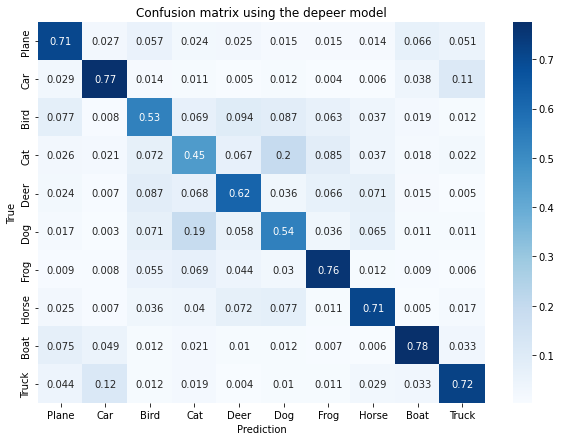

In [ ]:
y_test_pred = model2.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)
fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label,normalize="true")
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the depeer model")
plt.show()

On this model, we face similar problems that we encountered with the first one. Basically, the bird, cat, deer and dog classes have more difficulty being identified correctly. As we had already mentioned, this result looks quite good in general, but we have to remember that it is a model with a lot of overfitting that will not get better results with other datasets as its ability to generalize is practically inexistent.

*    **Print the test accuracy for the trained model.**

In [ ]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 3.6836 - accuracy: 0.6588
Test loss: 3.683579683303833
Test accuracy: 0.6588000059127808


We can see that the resulting accuracy of the deeper model improves slightly compared with the first model. However, we would like to expect higher accuracy with a non-overfitted model that is able to generalize for new data in a proper way. Let's see how a bigger model can perform with the following VGG architecture.